<a href="https://colab.research.google.com/github/LuoZYi/Deepfake-Face-Detection/blob/main/VGG_Real_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '140k-real-and-fake-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F501529%2F939937%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T074345Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da5a74622e492b9862e04322a98166e8a8a49af59b88537e7f9efc200b2d932b0c7277fdb4eed42a3d66e0c9f2ad10a37e4b13eb79f9c0d14836dae58b73f0f7912ecb459b2ed4d4f6933d5363d9c21432e7199ae6ee8f99b9608df95157ae82d7b457c450af4186cd56c0fa52fece2593f35f5288f5a1bc06f06fa85ffe3b87bb9aaae6f2b6cf2c68cc7e183021970891196cda597144ee3eaf3dbfd80ddbc8b461871b0d89815260ec5785cc9218cbd04ad14103d9cafb31c68554248dcdc97e05dc0219867891573ec0eeff9fd6ef18568a4a1028fe3c2e1b85e1301a3cd94dc73e28e36deb0bc55f78bc694eda13159518b135f84edd4aec5ebc7b1c5a9b0,deepfake-and-real-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1909705%2F3134515%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T074345Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51269b437b9c5069bbfe4c552ba17bad93846fc6d7ade4d23c91125c02ed8e17ea07ad89d44567c023b2fbae8a5c0bb29ac9b4b7b85531ca0509a0a29ff7f1ac02dbbfa54783ba26e83c5b7838e8db670b7caf70550230ffdd38110dfd5442954fe57e82db7d9778784b5fa212c5af3c57bfbf1638252cb79b31e25afde1c04e2ba2dfc6b44731d4485b80a5d72c840ebfed6e8fbb0e199ae225cbcaed8aff1e0510a081a1fb2c83199e0eaeb605a34d73d93196b19b2e8e5c73bab2d204d0a6b627f674ecdcf1297f004271f4db0fd832106f0ded3c8617a8d2935de4e25b6a9d90d471b9afcc8e3bf42525d76af3ec9c8bb0a426cc82dd5cfc0932e315d185,real-vs-ai-generated-faces-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4270700%2F7353626%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T074345Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1240acbc2fbcdeecbab757521a988543d493693b8aa11ffd92e3846dd7be27d07d4d653bd3333b82067b2ce6a1b39a606c42fbea8fb4f023c60ea060f8ab8a4317bd934adc87a73e2db5a5f58ee79a2d5a8739e0aa80a7a02d48f2fc4b618090de085bc25bcbcc0348cc7a66707bf23d57fa409c7744cc22b4b113a16a0af7a1bbcda3c5afea70ea2444fb72788352da81b8a5d715a604ce76e6a6af78b0493c45f0efbc74d76ad738d56d5bada1f64c218750c887f2200520d6d0340a04fae761740bf76761aa245a30ff7b497c1d87cde4ca33385cf3ba93e81e3f411f589911115c6da1f6b8deb51513e21dabe322e60196474f8158e965e69c6f33966f39'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4024555718 bytes downloaded
Downloaded and uncompressed: 140k-real-and-fake-faces
[==================================================] 1808722718 bytes downloaded
Downloaded and uncompressed: deepfake-and-real-images
[==================================================] 7717595535 bytes downloaded
Downloaded and uncompressed: real-vs-ai-generated-faces-dataset
Data source import complete.


## DenseNet (More Combined dataset)

In [2]:
import os
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from keras.applications import VGG16
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [3]:
tf.__version__

'2.15.0'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Examining the data (Combined data from both dataset)

In [6]:
dataset_paths = ['/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/',
                 '/kaggle/input/deepfake-and-real-images/Dataset/',
                 '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/']

In [7]:
status_map = {"0":"real",
              "1":"fake",
              "fake":"fake",
              "real":"real"}

where_map = {"train" : "train",
             "test" : "test",
             "valid" : "valid",
             "validate" : "valid",
             "validation" : "valid"}

In [8]:
pd.options.display.max_colwidth = 100

dataset = {"image_path":[],"img_status":[],"where":[]}
for path in dataset_paths:
    for where in os.listdir(path):
        for status in os.listdir(path+"/"+where):
            for image in glob.glob(path+where+"/"+status+"/"+"*.jpg"):
                dataset["image_path"].append(image)
                dataset["img_status"].append(status_map.get(status.lower()))
                dataset["where"].append(where_map.get(where.lower()))


dataset = pd.DataFrame(dataset)
dataset

,image_path,img_status,where
0,/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/45557.jpg,real,valid
1,/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/45426.jpg,real,valid
2,/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/30743.jpg,real,valid
3,/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/46888.jpg,real,valid
4,/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/01335.jpg,real,valid
...,...,...,...
451284,/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/test/1/SFHQ_pt3_00000624.jpg,fake,test
451285,/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/test/1/9092b66098a4f6664c167d6b...,fake,test
451286,/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/test/1/37e3df234dd19403a8d63f5f...,fake,test
451287,/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/test/1/4e423ed962d63f35540e1d58...,fake,test


In [9]:
print(dataset.value_counts("img_status"),'\n')
print(dataset.value_counts("where"))

img_status
real    235201
fake    216088
Name: count, dtype: int64 

where
train    312576
valid     83618
test      55095
Name: count, dtype: int64


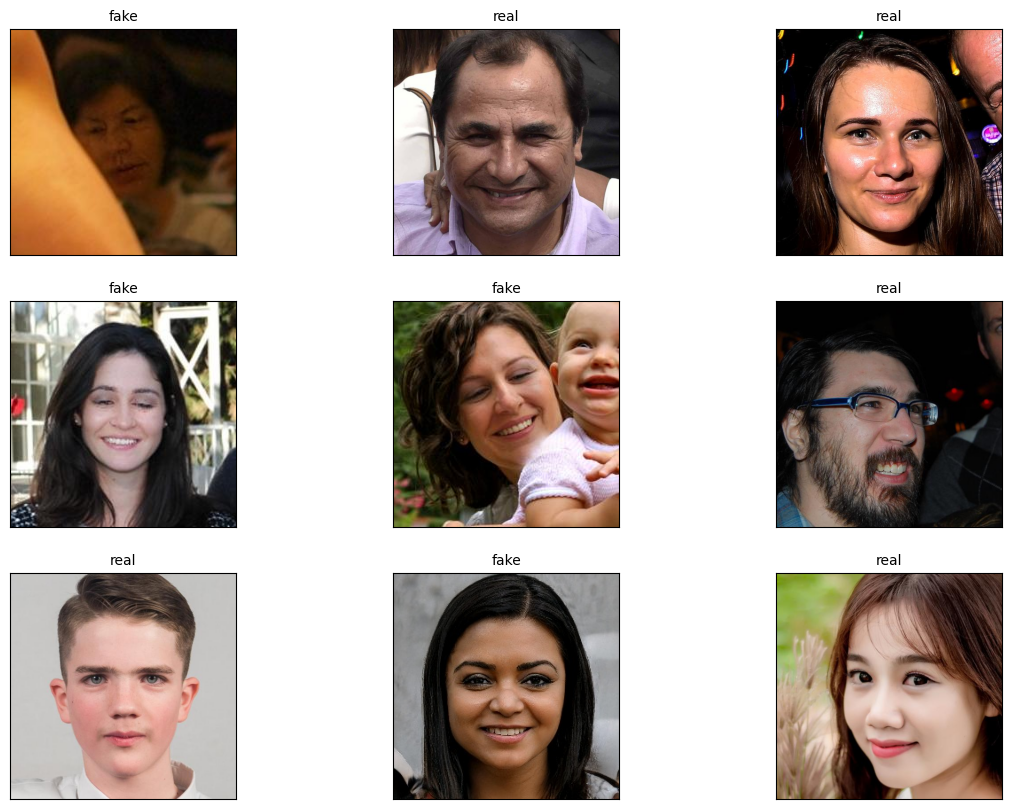

In [10]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "img_status"], size = 10)
    plt.xticks([])
    plt.yticks([])

plt.show()

### Processing the data

In [11]:
test_df = dataset[dataset['where'] == 'test'].drop('where', axis=1)
valid_df = dataset[dataset['where'] == 'valid'].drop('where', axis=1)
train_df = dataset[dataset['where'] == 'train'].drop('where', axis=1)

In [12]:
output_path = "/kaggle/working/"

try:
    os.mkdir(output_path + "model/")
except OSError as error:
    print(error)

try:
    os.mkdir(output_path + "model/cp/")
except OSError as error:
    print(error)

model_dir = output_path + "model/"
checkpoint_dir = model_dir + "cp/"

In [13]:
tf.random.set_seed(42)
img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                               directory=None,
                                               x_col='image_path',
                                               y_col='img_status',
                                               batch_size=32,
                                               target_size=(img_height, img_width),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                               directory=None,
                                               x_col='image_path',
                                               y_col='img_status',
                                               batch_size=32,
                                               target_size=(img_height, img_width),
                                               class_mode="binary",
                                               seed=42)

test_data = test_datagen.flow_from_dataframe(dataframe=test_df,
                                               directory=None,
                                               x_col='image_path',
                                               y_col='img_status',
                                               batch_size=1,
                                               target_size=(img_height, img_width),
                                               class_mode="binary",
                                               shuffle=False,
                                               seed=42)

Found 312576 validated image filenames belonging to 2 classes.
Found 83618 validated image filenames belonging to 2 classes.
Found 55095 validated image filenames belonging to 2 classes.


### Create and train the model

In [41]:
model_name = "VGG_model"

def create_model():
    base_model = VGG16(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3)
        #pooling = 'max'
    )

    base_model.trainable = False
    model = Sequential([base_model,
                        #layers.Flatten(),
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.Dropout(0.2),
                        layers.Dense(128,activation='relu'),
                        layers.Dropout(0.2),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [42]:
model = create_model()

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               65664     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                      

### Model checkpoint

In [43]:
checkpoint_path = checkpoint_dir + model_name +"_cp.keras"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 verbose=1,
                                                 patience=2)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     min_delta=0.01,
                                                     patience=4,
                                                     verbose=1,
                                                     restore_best_weights=True
                                                    )

In [44]:
model_history = model.fit(train_data,
    epochs = 16,
    steps_per_epoch = 1024,
    validation_data = valid_data,
    validation_steps = 1024,
    callbacks = [checkpoint_cb, reduce_lr, early_stopping_cb]
)

Epoch 1/16
1024/1024 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.6204
Epoch 1: val_loss improved from inf to 0.64355, saving model to /kaggle/working/model/cp/VGG_model_cp.keras
1024/1024 [==============================] - 478s 465ms/step - loss: 0.6488 - accuracy: 0.6204 - val_loss: 0.6435 - val_accuracy: 0.6302 - lr: 5.0000e-04
Epoch 2/16
1024/1024 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.6538
Epoch 2: val_loss improved from 0.64355 to 0.62846, saving model to /kaggle/working/model/cp/VGG_model_cp.keras
1024/1024 [==============================] - 478s 466ms/step - loss: 0.6186 - accuracy: 0.6538 - val_loss: 0.6285 - val_accuracy: 0.6526 - lr: 5.0000e-04
Epoch 3/16
1024/1024 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.6707
Epoch 3: val_loss improved from 0.62846 to 0.59102, saving model to /kaggle/working/model/cp/VGG_model_cp.keras
1024/1024 [==============================] - 475s 464ms/step - los

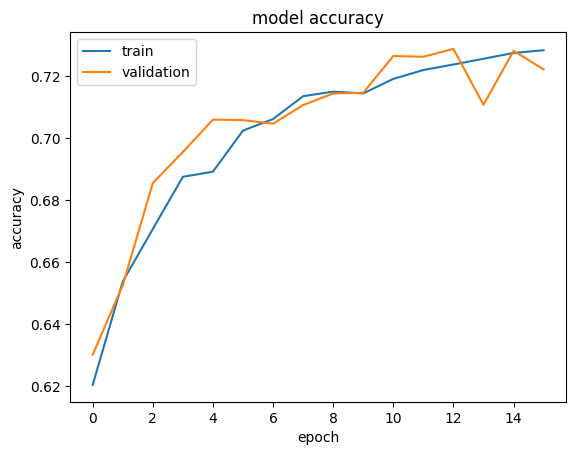

In [45]:
plot_hist(model_history)

### Evaluate the model

In [46]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

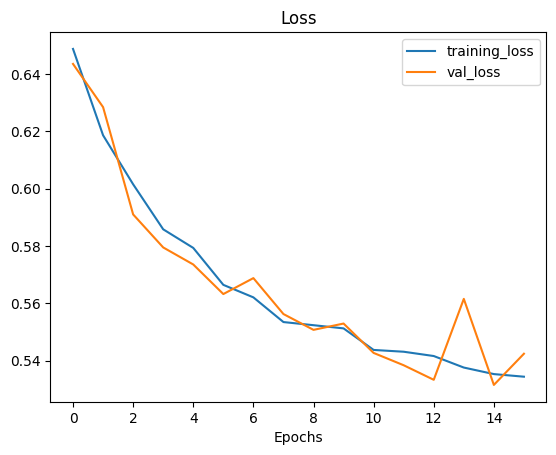

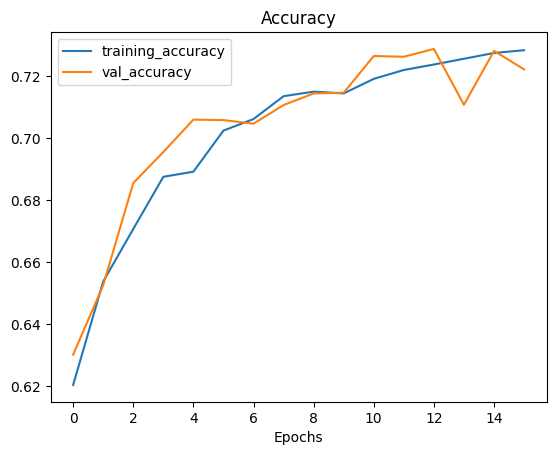

In [47]:
plot_loss_curves(model_history)

In [48]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# func to generate different score and confusion matrix from test score.
def gen_test_data(model):
    # Generate Confusion Matrix
    y_pred = model.predict(test_data)
    y_test = test_data.classes

#     y_pred_labels = np.argmax(y_pred, axis=1)
    y_pred_labels = (y_pred > 0.5).astype(np.float32)

    confusion_mat = confusion_matrix(y_test, y_pred_labels)
    print(confusion_mat)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])

    cm_display.plot(cmap="Blues")
    plt.show()

    # Get AUC, ROC and Precision Score
    print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
    print("AP Score:", metrics.average_precision_score(y_test, y_pred))
    print()
    print(metrics.classification_report(y_test, y_pred_labels))
    accu = np.sum(np.equal(y_test, y_pred_labels.reshape(-1))) / len(y_test)
    print('Final Test Acccuracy = {:.3f}'.format(accu*100))

55095/55095 [==============================] - 477s 9ms/step
[[18405  7277]
 [ 8445 20968]]


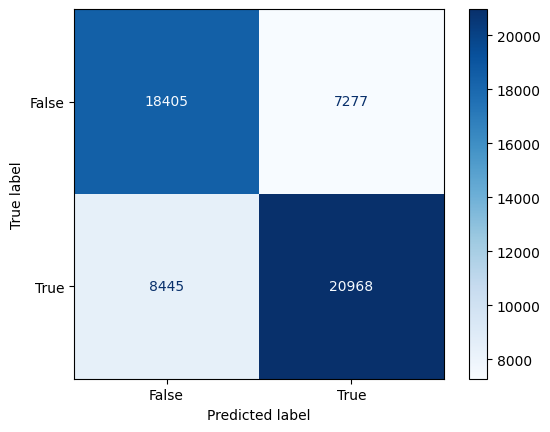

ROC AUC Score: 0.7851593554852488
AP Score: 0.7835880435938218

              precision    recall  f1-score   support

           0       0.69      0.72      0.70     25682
           1       0.74      0.71      0.73     29413

    accuracy                           0.71     55095
   macro avg       0.71      0.71      0.71     55095
weighted avg       0.72      0.71      0.71     55095

Final Test Acccuracy = 71.464


In [49]:
gen_test_data(model)

In [50]:
best_model = load_model(checkpoint_path, compile=False)
best_model.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

55095/55095 [==============================] - 478s 9ms/step
[[17686  7996]
 [ 7148 22265]]


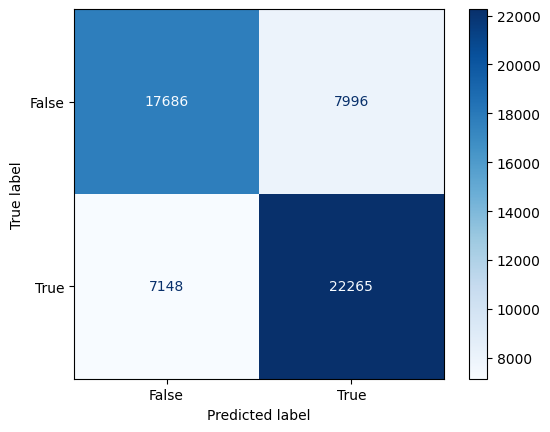

ROC AUC Score: 0.7939185404380449
AP Score: 0.7898327363639503

              precision    recall  f1-score   support

           0       0.71      0.69      0.70     25682
           1       0.74      0.76      0.75     29413

    accuracy                           0.73     55095
   macro avg       0.72      0.72      0.72     55095
weighted avg       0.72      0.73      0.72     55095

Final Test Acccuracy = 72.513


In [51]:
gen_test_data(best_model)

In [52]:
model.save(model_dir + model_name + "_last.keras")
best_model.save(model_dir + model_name + "_best.keras")

### Testing load and run model

In [53]:
load_test = load_model(model_dir + model_name + "_last.keras", compile=False)
load_test.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

55095/55095 [==============================] - 478s 9ms/step
[[18405  7277]
 [ 8445 20968]]


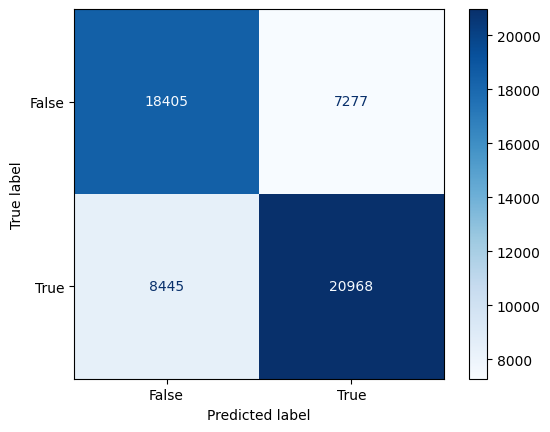

ROC AUC Score: 0.7851593554852488
AP Score: 0.7835880435938218

              precision    recall  f1-score   support

           0       0.69      0.72      0.70     25682
           1       0.74      0.71      0.73     29413

    accuracy                           0.71     55095
   macro avg       0.71      0.71      0.71     55095
weighted avg       0.72      0.71      0.71     55095

Final Test Acccuracy = 71.464


In [54]:
gen_test_data(load_test)